In [3]:
!pip install --quiet bayesian-torch

In [4]:
#Importing required libraries 
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F 

from tqdm.notebook import tqdm 
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

In [5]:
import pickle
with open('tasks_data.pkl','rb') as f:
    tasks_obj = pickle.load(f)   

In [6]:
import random 
def generate_client_data(task_data,clients): # task_data is train data of task 0 (tuple)
    data_label_mapping = [(task_data[0][i],task_data[1][i]) for i in range(len(task_data[0]))]
    random.shuffle(data_label_mapping)  
    client_data = {}

    start_div = 0
    fragment_size = len(data_label_mapping)//clients
    for i in range(clients):
        client_data[i+1] = data_label_mapping[start_div:start_div+fragment_size]
        start_div = start_div + fragment_size 
    return client_data

In [7]:
class Train_Dataset(torch.utils.data.Dataset):

    def __init__(self,train_set):
        self.train_set = train_set
    
    def __len__(self):
        return len(self.train_set)

    def __getitem__(self,index):
        x = self.train_set[index][0] 
        y = self.train_set[index][1]

        return x,y     

In [8]:
class Test_Dataset(torch.utils.data.Dataset):

    def __init__(self,test_set):
        self.test_set = test_set
    
    def __len__(self):
        return len(self.test_set[0])
    
    def __getitem__(self,index):
        x = self.test_set[0][index]
        y = self.test_set[1][index]

        return x,y

In [9]:
task_dataloaders = {}
task_testloaders = {}
for task in range(len(tasks_obj)):
    task_data = tasks_obj[task][0]
    client_data_dict = generate_client_data(task_data,5) 
    client_dataloaders = []
    num_clients = 5

    for client in range(1,num_clients+1):
        dataloader = torch.utils.data.DataLoader(Train_Dataset(client_data_dict[client]),batch_size=64,shuffle=True)
        client_dataloaders.append(dataloader) 
    
    testloader = torch.utils.data.DataLoader(Test_Dataset(tasks_obj[task][1]),batch_size=64) 
    task_dataloaders[task+1] = client_dataloaders
    task_testloaders[task+1] = testloader 

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [11]:
import torch
import torch.optim as optim
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1)

In [12]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [13]:
pfed_coeff = 1/ewc_lambda

In [14]:
class FedAvg_ClientUpdate(object):
    
    def __init__(self, train_loader, round):

        self.train_loader =  train_loader
        self.curr_round = round
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):   
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        
        train_losses = []
        train_accs = []


        layer_list = [name for name,_ in net.named_parameters()]

        # Loop over epochs
        for _ in range(max_epochs):
            
            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad() 

                # Model computations
                # forward + backward + optimize

                batch_train_outputs = net(train_data) 
                loss = self.criterion(batch_train_outputs, train_labels)

                param_dict = net.named_parameters()

                for round_num in range(self.curr_round):
                    #for name, param in net.named_parameters():
                    optpar = optpar_dict[round_num]
                    for layer in range(len(layer_list),2):
                        fisher = fisher_dict[round_num][layer_list[layer]] 
                        kl_factor = kl_divergence(Normal(param_dict[layer_list[layer]],param_dict[layer_list[layer+1]]),Normal(optpar[layer_list[layer]],optpar[layer_list[layer+1]]))
                        
                        loss += (fisher * kl_factor) * pfed_coeff

                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1

           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict 

In [15]:
def on_round_update(round_id, dataloader, model):

  model.train()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  optimizer.zero_grad()
  
  # accumulating gradients
  for batch in dataloader:
      x, y = batch
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[round_id] = {}
  optpar_dict[round_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[round_id][name] = param.data.clone()
    fisher_dict[round_id][name] = param.grad.data.clone().pow(2)

In [16]:
def test_model(FedAvg_Model,tasks):
    task_accs = []
    with torch.set_grad_enabled(False):
        for task in range(tasks+1):
            val_acc = 0
            val_cnt = 0
            running_valloss = 0
            criterion_FedAvg = nn.CrossEntropyLoss()

            testloader = task_testloaders[task+1]
            
            for val_data, val_labels in testloader:
                # Transfer to GPU
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = FedAvg_Model(val_data) #[64,10]
                
                val_loss = criterion_FedAvg(batch_outputs, val_labels.long())

                running_valloss += val_loss.item()

                val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels) #.numel--> product of dim's
                #long --> converts to int64                                                                               # [64,1] --> 64*1
                val_acc = val_acc.item()
                val_cnt += 1
            
            task_accs.append(np.round(val_acc/val_cnt*100,2))

    return task_accs
        

In [17]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}
    

FedAvg_Model = Net()
dnn_to_bnn(FedAvg_Model, const_bnn_prior_parameters)
FedAvg_Model = FedAvg_Model.to(device)

In [18]:
# Define Loss function and Optimizer
criterion_FedAvg = nn.CrossEntropyLoss()

train_losses_FedAvg = []
validation_losses_FedAvg = []

task_accuracies = {}

train_accs_FedAvg = []
val_accs_FedAvg = []

max_rounds = 3
E = 10
learning_rate = 0.001
w_dict = copy.deepcopy(FedAvg_Model.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    #clients = random.sample(list(np.arange(n)), k = int(C * n))
    #clients = np.arange(num_clients)
    coeffs = [1 / (num_clients) for i in range(num_clients)]
    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in range(num_clients):
        cl_upd = FedAvg_ClientUpdate(task_dataloaders[round+1][i], round) 
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(FedAvg_Model).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    
    FedAvg_Model.load_state_dict(w_dict) # for calculating fisher I'm sending the data of last client
    on_round_update(round, task_dataloaders[round+1][num_clients-1], FedAvg_Model)

    task_accs = test_model(FedAvg_Model,round)


    learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 

    for task,task_acc in enumerate(task_accs):
        print(f"Accuracy on Validation data of task {task+1}:{task_acc}")
        if task+1 in task_accuracies.keys():
            task_accuracies[task+1].append(task_acc)
        else:
            task_accuracies[task+1] = [task_acc]

    print("-"*10)

  0%|          | 0/3 [00:00<?, ?it/s]

Cost of Train data for client 1 in round 1 for 10 epochs: 1.601268
Cost of Train data for client 2 in round 1 for 10 epochs: 1.594011
Cost of Train data for client 3 in round 1 for 10 epochs: 1.587578
Cost of Train data for client 4 in round 1 for 10 epochs: 1.614635
Cost of Train data for client 5 in round 1 for 10 epochs: 1.631524
----------
Cost of Train data for in round 1: 1.605803
Acc of Train data for in round 1: 42.502831
Accuracy on Validation data of task 1:74.65
----------
Cost of Train data for client 1 in round 2 for 10 epochs: 1.620236
Cost of Train data for client 2 in round 2 for 10 epochs: 1.619223
Cost of Train data for client 3 in round 2 for 10 epochs: 1.653823
Cost of Train data for client 4 in round 2 for 10 epochs: 1.637527
Cost of Train data for client 5 in round 2 for 10 epochs: 1.624949
----------
Cost of Train data for in round 2: 1.631152
Acc of Train data for in round 2: 43.109207
Accuracy on Validation data of task 1:30.8
Accuracy on Validation data of tas

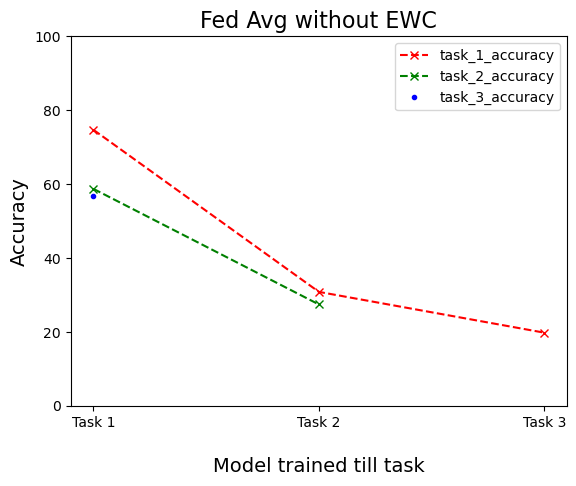

In [19]:
plt.plot(task_accuracies[1],linestyle='--',color='red',marker='x')
plt.plot(task_accuracies[2],linestyle='--',color='green',marker = 'x')
plt.plot(task_accuracies[3],linestyle = '',color='blue',marker = '.')

plt.legend(['task_1_accuracy','task_2_accuracy','task_3_accuracy'])

plt.xticks(ticks=[0,1,2],labels = ['Task 1','Task 2','Task 3'],rotation=0)

plt.title("Fed Avg without EWC",fontsize = 16)
plt.xlabel("\nModel trained till task",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)

plt.ylim(0,100)

plt.show()